# 2.3 优化提示词改善答疑机器人回答质量

## 🚄 前言

上一节，你学习了**上下文工程 (Context Engineering)** 的一种关键技术——RAG，通过为大模型提供外部知识来扩展其能力。但这仅仅是构建优秀用户体验的第一步。用户往往期待更个性化、更精准的交互。

本节将深入探索上下文工程的另一重要方面：如何通过优化**提示词 (Prompt)** 来精细地控制大模型的输出，例如调整语气、规范格式，甚至赋予它处理文本总结、推断、转换等多种任务的能力。

## 🍁 课程目标

学完本节课程后，你将能够：

* 了解提示词框架和模板
* 了解提示词技巧和最佳实践
* 学习在工程中应用大模型处理多种不同类型的任务

## 1. 前文回顾

上一节中通过RAG方法，大模型已经获取到了公司的私有知识。为了方便调用，将其封装成了几个函数，并保存在了 chatbot/rag.py 中。 现在你可以通过如下代码来快速调用。

In [ ]:
import os

# 环境变量中指定 base_url
os.environ["BASE_URL"] = "https://dashscope.aliyuncs.com/compatible-mode/v1"

from config.load_key import load_key
# 加载API密钥
load_key()
print(f'''你配置的 API Key 是：{os.environ["DASHSCOPE_API_KEY"][:5]+"*"*5}''')

In [ ]:
from chatbot import rag, llm
# 加载索引
# 上小节已经建立了索引，因此这里可以直接加载索引。如果需要重建索引，可以增加一行代码：rag.indexing()
index = rag.load_index()
query_engine = rag.create_query_engine(index=index)

In [ ]:
# 定义问答函数
def ask_llm(question, query_engine):
    streaming_response = query_engine.query(question)
    streaming_response.print_response_stream()

## 2. 优化提示词以改善大模型回答质量

上一节，你已经成功地让答疑机器人通过 RAG 掌握了公司的内部知识。现在，你可以测试一下它的实际效果。一位新同事想了解项目管理工具，于是他向机器人发起了提问：


In [ ]:
# 仅使用RAG时，机器人的表现
question = "我们公司项目管理应该用什么工具？"
ask_llm(question, query_engine)

预期输出（示例）：
```
公司项目管理可以使用Jira或Trello等项目管理软件。这些工具能够帮助团队更好地规划和跟踪项目的进度，确保任务按时完成。同时，它们还支持任务分配、时间跟踪和团队协作等功能，有助于提高工作效率。
```

这个回答是正确的，但不够“好用”。同事反馈说：“如果能直接附上工具的链接就完美了，省得我再去到处找。”

这个需求非常合理。一个最直观、最“暴力”的解决方法，或许是在用户的问题后面，手动加上一句指令：

In [ ]:
# 尝试一个简单的“补丁”
question = "我们公司项目管理应该用什么工具？"
instruction = " 回答时请务必附带上工具的官方网站或下载链接。"
 
# 将问题和指令简单地拼接在一起
new_question = question + instruction
ask_llm(new_question, query_engine)

预期输出（示例）：
```
对于项目管理，推荐使用 Jira 或 Trello。这两个工具都非常适合管理和跟踪项目进度，确保团队成员之间的高效协作。

- **Jira** 是一个非常强大的项目管理工具，特别适用于软件开发项目。它可以帮助你跟踪问题和任务，管理项目进度。你可以访问 [Atlassian官网](https://www.atlassian.com/software/jira) 获取更多信息或下载。

- **Trello** 则是一个更加灵活的看板式项目管理工具，适合各种类型的项目。通过卡片和列表的形式，可以直观地看到项目的进展。你可以访问 [Trello官网](https://trello.com/) 获取更多信息或注册使用。
```

问题似乎解决了。但……真的解决了吗？

你需要考虑另一个场景，当用户问一个跟工具无关的问题时：

In [ ]:
# 看看这个“补丁”在其他问题上的表现
question_2 = "我们公司的年假有多少天？"
instruction = " 回答时请务必附带上工具的官方网站或下载链接。"
 
new_question_2 = question_2 + instruction
ask_llm(new_question_2, query_engine)

预期输出（示例）：
```
您的问题涉及到具体的公司福利政策，特别是年假天数，但提供的信息中并没有直接提到这一点。通常这类详细信息会记录在员工手册或者公司内部的人力资源政策文件中。建议您直接联系人力资源部获取准确的信息。人力资源部的联系人是熊伟，您可以发送邮件至xiongwei@educompany.com询问具体事宜。

至于您要求的工具官方网站或下载链接，由于您的问题并未提及需要使用哪个工具，因此无法提供相关链接。
```

现在，问题暴露了。这种“一刀切”地拼接指令的方式非常脆弱。它不仅可能让模型的回答变得啰嗦和奇怪，而且每次提问都要手动判断该拼接哪句指令，这在真实的应用中是完全不可行的。

**这正是深入学习提示词工程（Prompt Engineering）的原因**。 它属于 **上下文工程（Context Engineering）** 的一部分，教你如何不再使用这种临时的“补丁”，而是系统性地、智能地构建与模型的对话上下文，精确地“指导”模型如何根据不同的情况来回答问题。

## 3. 提示词框架

### 3.1 基本要素

当和大模型在交流时，可以将它想象是一个经过“社会化训练的”人，交流方式应当和人与人之间传递信息的方式一样。你的需求需要清晰明确，不能有歧义。你的提问方式（Prompt）越清晰明确，大模型越能抓住问题的关键点，回复就越符合你的预期。为了系统性地构建高效的上下文，我们可以遵循一个包含多个基本要素的提示词框架：**任务目标、上下文、角色、受众、样例、输出格式**。这些要素共同构成了一个完整的上下文“蓝图”，能帮助你构建一个完整、有效的提示词。

|要素|含义|
|----|----|
|任务目标（Object）|明确要求大模型完成什么任务，让大模型专注具体目标|
|上下文（Context）|任务的背景信息，比如操作流程、任务场景等，明确大模型理解讨论的范围|
|角色（Role）|大模型扮演的角色，或者强调大模型应该使用的语气、写作风格等，明确大模型回应的预期情感|
|受众（Audience）|明确大模型针对的特定受众，约束大模型的应答风格|
|样例（Sample）|让大模型参考的具体案例，大模型会从中抽象出实现方案、需要注意的具体格式等信息|
|输出格式（Output Format）|明确指定输出的格式、输出类型、枚举值的范围。通常也会明确指出不需要输出的内容和不期望的信息，可以结合样例来进一步明确输出的格式和输出方法|

当然，除了上面讲的提示词框架，许多问题分析的思维范式都可以用来帮助你描述清晰具体的需求。例如，SWOT分析法、5W2H分析法等。另外，你也可以考虑使用阿里云百炼提供的[提示词自动优化工具](https://bailian.console.aliyun.com/?tab=app#/component-manage/prompt/optimize)，来帮助你完善提示词。

<a href="https://img.alicdn.com/imgextra/i3/O1CN014JCCqn22zX6xB4tt3_!!6000000007191-0-tps-2068-1052.jpg" target="_blank">
<img src="https://img.alicdn.com/imgextra/i3/O1CN014JCCqn22zX6xB4tt3_!!6000000007191-0-tps-2068-1052.jpg" width="700"/>
</a>

### 3.2 提示词模板

在开发大模型应用时，直接让用户根据框架书写提示词并非最佳选择。你可以参考各种提示词框架中的要素，构建一个提示词模板。提示词模板可以预设部分信息，如大模型的角色、注意事项等，以此来约束大模型的行为。开发者只需在模板中配置输入参数，便能创建标准化的大模型的应用。

使用 LlamaIndex 中创建的 RAG应用中，有个默认的提示词模板，如下所示：

- 默认的模板可以使用代码查看，你可以参考[LlamaIndex官网的代码。](https://developers.llamaindex.ai/python/examples/prompts/prompt_mixin/#customize-the-prompt)LlamaIndex原始prompt模板为：

```text
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
```

其中，`context_str`和`query_str`都表示变量。在进行向量检索和提问过程中，`context_str`将替换为从向量库中检索到的上下文信息，`query_str`则替换为用户的问题。

由于原模板是通用模板，不适合用来约束答疑机器人的行为。你可以通过下列示例代码重新调整提示词模板，其中`prompt_template_string`表示新的提示词模板，你可以根据自己的场景自行修改。

In [ ]:
# 构建提示词模板
prompt_template_string = (
    "你是公司的客服小蜜，你需要简明扼要的回答用户的问题"
    "【注意事项】：\n"
    "1. 依据上下文信息来回答用户问题。\n"
    "2. 你只需要回答用户的问题，不要输出其他信息\n"
    "以下是参考信息。"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "问题：{query_str}\n。"
    "回答："
)

# 更新提示词模板
rag.update_prompt_template(query_engine,prompt_template_string)

## 4. 构建有效提示词的技巧

在3.1中列举了一些提示词设计中的要素，接下来将从提示词要素出发，结合具体场景展开讲解提示词技巧。

### 4.1 清晰表达需求，并使用分隔符

明确的表达需求可以确保大模型生成的内容与任务高度相关。需求包括任务目标、背景及上下文信息，还可以使用分隔符将各种提示词要素隔开。

分隔符可以使大模型抓住具体的目标，避免模糊的理解，也减少对不必要信息的处理。分隔符一般可以选择 “**【】**”、“**<< >>**”、“**###**”来标识关键要素，用“**===**”、“**---**”来分隔段落，或者使用xml标签如`<tag> </tag>`来对特定段落进行标识。当然，分隔符不止上述提到的几种，只需要起到明确阻隔的作用即可。需要注意的是，如果提示词中已大量使用某种符号（如【】），则应避免用该符号作为分隔符，以防混淆。

在下面的示例中，将基于3.2中的提示词模板，以答疑机器人的身份帮你完成文档润色。

- 你需要运行3.2中的代码，才能使新的提示词模板生效。

In [ ]:
question = """
把下列【】括起来的文本进行扩写和润色，让文案生动且富有创造力，并且受到公司新员工的喜欢。
【新员工训练营活动】
"""
ask_llm(question,query_engine)

由上述运行结果可以发现，提示词中明确了任务需求：对文本进行扩写和润色，任务主题为“**新员工训练营活动**”，受众为“**公司员工**”，并使用了“**【】**”分隔符分隔了文本。使用这样的提示词，让输出的文本不仅保持了原本的含义，还更加生动有趣。

### 4.2 限定角色和受众

角色指大模型在特定场景下应扮演的身份，如专家、顾问或助手。受众是使用模型输出的目标用户群体，如普通消费者或学生。这有助于开发者定制内容的风格和深度。以下示例将展示不同的系统角色对输出文本风格和内容的影响，用户的问题为：qwen-vl是什么？

- 以下仅演示提示词模板和输出的内容，你可以将提示词模板传入到`prompt_template_string`中，将用户问题传入到`question`中，再调用`ask_llm`函数。

<table>
  <thead>
    <tr>
      <th width = '80px'>角色</th>
      <th width = '500px'>大模型算法工程师</th>
      <th width = '500px'>小学老师</th>
    </tr>
  </thead>
  <tbody valign = 'top'>
    <tr>
      <td>提示模板</td>
      <td>"你是资深的大模型算法工程师，请根据用户的问题进行解答\n"<br>"---------------------\n"<br>"{context_str}\n"<br>"---------------------\n"<br>"问题：{query_str}\n。"<br>"回答："</td>
      <td>"你是一名小学老师，请根据用户的问题进行解答\n"<br>"---------------------\n"<br>"{context_str}\n"<br>"---------------------\n"<br>"问题：{query_str}\n。"<br>"回答："</td>
    </tr>
    <tr>
      <td>用户问题</td>
      <td>Qwen-VL</td>
      <td>Qwen-VL</td>
    </tr>
    <tr>
      <td>输出回答</td>
      <td>Qwen-VL是阿里巴巴云推出的一种多模态预训练模型，它结合了文本和图像处理能力，能够理解和生成与图像相关的文本描述。简单来说，Qwen-VL可以看作是一个能够“看图说话”的人工智能助手，它不仅能够理解图片的内容，还能根据图片内容生成相应的文字描述或回答相关问题。这种技术在多个领域都有广泛的应用前景，比如自动图像标注、视觉问答系统、基于内容的图像搜索等。对于新媒体运营而言，Qwen-VL这样的工具可以帮助提高内容创作效率，增强用户体验，为用户提供更加丰富多元的信息展示方式。</td>
      <td>小朋友们，我们今天来认识一个新朋友，它的名字叫做Qwen-VL！<br>Qwen-VL就像是一个非常聪明的机器人，它拥有“眼睛”👀和“大脑”🧠。它能“看”图片、视频，还能理解它们的意思，就像我们一样！<br>比如，你给它看一张小猫玩毛线球的图片，它不仅能认出这是一只小猫🐱，还能告诉你它在玩毛线球🧶。 更厉害的是，你还可以问它：“小猫是什么颜色的？”，它就能告诉你小猫的颜色。<br>它还能理解视频里的内容，比如你给它看一段小朋友们踢足球⚽️的视频，它能告诉你谁在踢球，球踢到了哪里，甚至还能猜到接下来可能会发生什么！<br>Qwen-VL就像一个正在学习的小朋友，它还在不断地学习和进步，将来它会变得更聪明，能做更多的事情，帮助我们更好地了解这个世界！</td>
    </tr>
  </tbody>
</table>


### 4.3 规定输出格式
有时候，开发者在设计大模型应用时，需要采用结构化的数据作为下游系统的输入，才能完成整个应用的开发，但是一般大模型是输出连续的文本。不用担心，大模型有结构化输出的能力。你只需在提示词中指定输出的格式和要求，大模型有很大可能会输出结构化的内容。

在下面的示例中，将基于3.2中的提示词模板，以答疑机器人的身份帮助公司开发的文档进行文档质量审查，并将结果以json的格式输出：

In [ ]:
question_task= """
【任务要求】
你将看到一句话或一段话。你需要审查这段话中有没有错别字。如果出现了错别字，你要指出错误，并给出解释。
 “的” 和 “地” 混淆不算错别字，没有错误
---
【输出要求】
请你只输出json格式，不要输出代码段
其中，label只能取0或1，0代表有错误，1代表没有错误
reason是错误的原因
correct是修正后的文档内容
---
【用户输入】
以下是用户输入，请审阅：
"""
question_doc = "分隔符是特殊的符号，它们帮助大语言模形 (LLM) 识别提示中哪些部分应当被视为一个完整的意思单元。"

question = question_task + question_doc
ask_llm(question, query_engine)

由上述示例的结果可知，在提示词`question_task`中注明了输出格式为json，也规定了输出的内容，大模型成功的输出了格式化的内容。这种稳定的格式化输出，使得在现有的系统中接入大模型这个操作变得具有可行性。

在新闻网站、博客平台或企业内部的知识分享平台上，用户编辑或发布的文章可能会包含错别字、语法错误、甚至是敏感信息。但是传统的人工审核方式很容易出疏漏。这时候可以接入大模型来对内容做审查工作。如果文章被标记为存在严重语法错误或含有高风险敏感词汇，则将其修改的优先级设置为“高”。对于轻微问题的文章，则可以将其修改的优先级设置为“低”。这样会节省人力成本，提高系统的效率与准确性。

当然了，类似于上述场景的应用非常多，开发者可以分析系统中流程的瓶颈或者关注数据密集型的任务，探索更多的大模型应用场景。

### 4.4 提供少样本示例

在4.3的例子中，提示词规定了输出的格式，大模型成功生成了格式化的内容。然而，如果希望大模型输出的内容不仅格式正确，而且风格和结构也保持一致，可以提供几个样例作为参考。这相当于给大模型提供了一本“参考书”。下面的代码示例中，先观察下没有样例时的大模型的输出吧！

In [ ]:
question_task = """
【任务要求】
请你根据用户的主题，创作内容。
---
【输出要求】
最终输出需要以Markdown格式呈现，请注意，在你的回答中包含所有必要的Markdown元素，如标题、列表、链接、图片引用、加粗等，以便于阅读、后续编辑和保存。
---
【用户输入】
以下是用户的要求创作的主题：
"""
question_doc = "手工钥匙扣制作教程"

question = question_task + question_doc
ask_llm(question, query_engine)

上述示例大模型成功了输出了手工钥匙扣制作教程，但是内容不够简洁，如果只想大模型输出特定风格和结构的内容，如只输出主题、材料清单、步骤等内容，可以为大模型添加几个样例，让它去“模仿”！

In [ ]:
question_task= """
【任务要求】
请根据用户的主题，结合下面【样例】给的例子，理解和使用一致的风格和结构继续创作内容，不要输出多余的内容。
---
【输出要求】
最终输出需要以Markdown格式呈现，请注意，在你的回答中包含所有必要的Markdown元素，如标题、列表、链接、图片引用、加粗等，以便于阅读、后续编辑和保存。
---
【样例】
### 示例1: 制作简易书签
# 简易书签制作教程

## 材料清单
- 彩色卡纸
- 剪刀
- 装饰贴纸
- 铅笔

## 步骤
1. 选择一张彩色卡纸。
2. 用铅笔在卡纸上画出一个长方形，尺寸约为2英寸 x 6英寸。
3. 沿着铅笔线剪下长方形。
4. 使用装饰贴纸对书签进行个性化装饰。
5. 完成！现在你有了一个独一无二的书签。

## 结束语
希望这个教程能帮助你制作出满意的书签！

---
【用户输入】
以下是用户的要求创作的主题：
"""
question_doc = "制作手工贺卡"

question = question_task + question_doc
ask_llm(question, query_engine)

由上述示例结果可知，大模型完全按照了样例输出了相同结构和风格的内容。在提示词中规定输出格式的同时，建议提供几个样例供大模型参考，这样可以使得大模型的输出更加稳定和一致。

### 4.5 给模型“思考”的时间

对于一些复杂的任务来说，使用上面提到的提示词也许还不能帮助大模型完成任务。但是你可以通过让大模型一步步“思考”，引导大模型输出任务的中间步骤，允许大模型在进行推理之前，得到更多的依据，从而提升在复杂任务的表现能力。思维链（COT）方法是让模型进行思考的一种方法。它通过让模型处理中间步骤，逐步将复杂问题分解为子问题，最终推导出正确答案。

假设有这样的场景，让大模型计算下面这道数学题，在此先提示一下，这道题的正确答案为10500元。先使用简单的提示词：

In [ ]:
question = """
【背景信息】
某教育培训机构（以下简称“公司”）在2023年度发生了以下主要支出：
为了给不同城市的学校学生上课，公司的老师全年共出差了5次，每次出差时间为一周，具体费用如下：
   - 交通费及住宿费：平均1600元/次
   - 教学用具采购费用：公司在年初一次性购买了一批教学用具，总价为10000元，预计可以使用4年。
   
【问题描述】
请根据上述背景信息，完成以下任务：
计算全年因教师出差而产生的差旅总费用，包括摊销的教学用具。

【输出要求】
直接给出总差旅费用，不要其他信息"""

ask_llm(question, query_engine)

由上面的实验结果来看，大模型计算结果不正确。下面将使用COT方法，让大模型逐步进行思考。

In [ ]:
question = """某教育培训机构（以下简称“公司”）在2023年度发生了以下主要支出：
为了给不同城市的学校学生上课，公司的老师全年共出差了5次，每次出差时间为一周，具体费用如下：
   - 交通费及住宿费：平均1600元/次
   - 教学用具采购费用：公司在年初一次性购买了一批教学用具，总价为10000元，预计可以使用4年。
   
### 问题描述
请根据上述背景信息，完成以下任务：
计算全年因教师出差而产生的差旅总费用，包括摊销的教学用具。

### 输出要求
请你一步步推导，计算总差旅费用"""

ask_llm(question, query_engine)

经过优化后的提示词，大模型能够准确计算出结果。因此在开发大模型应用时，可以在提示词中添加思维链的方法，可以确保一些推理任务能正确执行。  

使大模型进行 “思考”的方法还有很多种，比如：思维树（ToT)、思维图（GOT） 等。但是就目前大模型的发展来说，仅靠引导大模型“思考”还是无法完成更复杂的工作。大模型也逐渐从COT的提示方法向多智能体（Agent）方向进行发展。你可以在<2.6 用插件扩展答疑机器人的能力边界>阅读详细内容。

### 4.6 Meta Prompting: 让大模型成为你的提示词教练

一次性就写好一个完美的提示词，往往非常困难。更常见的工作流是：
1.  写出第一版提示词。
2.  运行它，并分析输出结果中有哪些不符合预期的地方。
3.  总结问题，思考如何改进，然后修改提示词。
4.  不断重复这个迭代过程，直到满意为止。

你可以回想一下，这是否也是你优化提示词的常规路径？这个过程虽然有效，但非常依赖经验，也颇为耗时。

这时，你可能会想到：既然大模型这么强大，**这个分析、总结、改进的迭代过程，是否能让大模型自己来做呢？** 让它扮演“提示词评审专家”的角色，帮助我们分析和优化提示词，无疑会更高效。

答案是肯定的。这种**让你和模型一起“讨论”如何优化提示词本身**的方法，就叫做 **Meta Prompting**。

为了进一步理解这个强大的技巧，你可以来亲手实践一下。

#### 步骤 1：一个不甚理想的初始提示词

假设你的任务是优化答疑机器人的回答，让它在回答新员工关于“公司福利”的问题时，输出更友好、结构更清晰的内容。你可能会从一个简单的提示词开始：

In [ ]:
# 在真实的 RAG 应用中，这段文本会由你的向量数据库检索而来。
# 这里用一个字符串来模拟它，方便你进行实验。
retrieved_text = """
关于公司的福利政策，我们提供全面的健康保险，覆盖员工及其直系家属。
年度体检是标配。此外，每年有15天的带薪年假，以及5天的带薪病假。
我们还提供每月500元的交通补贴和300元的餐饮补贴。
为了鼓励员工成长，公司设有每年高达8000元的教育培训基金，员工可以申请用于课程学习或购买专业书籍。
健身方面，公司与多家健身房有合作，员工可享受折扣价。
"""

# 这是一个非常基础的提示词，只是简单地将任务和信息拼接起来。
initial_prompt = f"""
根据以下信息，回答新员工关于公司福利的问题。

【参考信息】
{retrieved_text}
"""

# 看看这个“朴素”的提示词会产生什么样的效果。
response = llm.invoke(initial_prompt)
print("--- 初始回答 ---")
print(response)

这个回答虽然包含了所有信息，但你可能会觉得，对于一个刚入职的新员工来说，它显得有些平淡和杂乱。它只是简单地复述了文本，没有重点，也缺乏热情的欢迎语气。

显然，这个效果没有达到你的预期。现在，你无需自己苦思冥想如何修改，而是可以尝试一种更高效的方法：**让大模型来帮你优化**。

#### 步骤 2：构建 Meta Prompt，让大模型提供优化建议

现在，你对这个平淡的回答不满意。你可以构建一个“Meta Prompt”，清晰地向模型描述你的目标（友好、结构化、重点突出），并将你那不甚理想的初始提示词和它产出的回答一并“喂”给大模型，请求它以“提示词工程专家”的身份，帮你改进。

In [ ]:
# 你需要将你的不满和期望清晰地表达出来，这是让AI教练理解你意图的关键。
meta_prompt = f"""
我正在为公司的新员工答疑机器人优化一个提示词，目标是回答关于“公司福利”的问题。

这是我的第一个尝试：
---
{initial_prompt}
---

这是它生成的输出：
---
{response}
---

这个输出不够好。我希望机器人的回答更具吸引力，并且结构清晰，能让新员工快速抓住重点。具体要求如下：
1.  **语气**：友好、热情，有欢迎新同事的感觉。
2.  **结构**：使用清晰的要点（比如用表情符号开头的列表）来组织内容。
3.  **内容**：将福利分为几个类别，如“健康与假期”、“补贴与激励”等。

请你扮演一位提示词工程专家，帮我重写这个提示词，以实现上述目标。
"""

# 现在，让AI教练开始工作，为你生成一个优化版的提示词。
optimization_suggestion = llm.invoke(meta_prompt)
print("--- 来自AI教练的优化建议 --")
print(optimization_suggestion)

观察AI教练给出的建议，你会发现，它给出的优化后提示词，很可能应用了你在前面章节学到的多种技巧，例如：

*   **明确角色** (例如，“你是一位热情、友好的入职伙伴”)
*   **清晰的任务描述** (例如，“根据提供的参考信息，生成一段关于公司福利的介绍”)
*   **规定输出格式和风格** (例如，“使用热情的欢迎语”、“用表情符号开头的列表”)

这证明，让模型扮演专家来优化提示词是完全可行的。

#### 步骤 3：使用优化后的提示词

现在，你可以直接将这位“AI教练”为你量身定做的提示词用于你的任务，看看效果如何。

In [ ]:
# 这是一个假设的、由AI教练建议的优化版提示词
# 在实际应用中，你可以直接使用 `optimization_suggestion` 的输出
# 这里为了演示，我们手动构建一个符合建议的提示词

optimized_prompt = f"""
【角色】
你是一位热情、友好的入职伙伴（Onboarding Buddy），你的任务是欢迎新同事，并清晰地介绍公司的福利政策。

【任务】
根据提供的【参考信息】，生成一段关于公司福利的介绍。

【输出要求】
1.  开头使用热情洋溢的欢迎语。
2.  将福利信息分类整理，例如分为“健康与假期”、“补贴与激励”等。
3.  每个福利项目前使用一个相关的表情符号，使其更生动。
4.  结尾表达对新同事的美好祝愿。

【参考信息】
{retrieved_text}
"""

# 使用优化后的提示词再次调用模型
final_response = llm.invoke(optimized_prompt)
print("--- 使用优化版提示词的回答 ---")
print(final_response)

通过这个迭代过程，你将得到一个语气热情、结构清晰的回答，这无疑会给新员工留下更好的第一印象。

这个例子展示了 Meta Prompting 在提升用户体验方面的巨大价值。它不仅仅是提取信息，更是关于**如何更好地呈现信息**。当你遇到一个棘手的提示词难题时，不要忘记，你的模型本身就是最好的教练。通过清晰地描述你的目标和困难，你可以引导它为你构建出更强大、更精确、也更有“人情味”的提示词。

在刚才的初步方案中，我们是向“AI教练”描述了我们期望的**定性目标**（如“友好”、“结构更清晰”），然后由它直接为我们生成一个优化后的提示词。这个方法很便捷，但它有一个关键的局限性：AI教练对这些定性目标的理解可能不够精确，你描述的需求也可能不够具体，这导致优化结果的好坏存在不确定性。

为了解决这个问题，让优化过程变得更可控、更精确，我们需要从“定性指导”升级到“量化对齐”。与其给出一个模糊的目标，不如直接给出一个完美的 **“参考答案”** 作为精确的靶子。接下来的进阶方案将向你展示如何利用这个“参考答案”，让大模型通过自动化的差距分析和迭代，逐步地、精确地向着最优结果逼近。这才是更具工程化的改进思路。

#### 多轮迭代：引入参考答案进行差距分析

在前面的例子中，你扮演了主导角色，接收“AI教练”的建议并手动应用它。但这个过程还可以进一步自动化和精确化。与其让评估者给出一个模糊的“好”或“不好”的判断，一个更高级的方法是引入一个 **“参考答案”（Reference Answer）**。

这个“参考答案”是你心目中最完美的理想答案，可以由人类专家撰写，也可以用一个非常详尽的提示词让最强大的模型生成。迭代优化的目标就变成了：**不断修改提示词，使其生成的回答与这个“参考答案”之间的差距越来越小**。

这个过程就像一个拥有精确制导系统的自我修正流程：

1.  **设定参考答案 (Set Reference Answer)**：首先，定义一个高质量的、理想的“参考答案”。
2.  **生成 (Generate)**：使用当前待优化的提示词，生成一个回答。
3.  **分析差距 (Analyze Gap)**：让一个“评估者”大模型（Critic）来比较“生成的回答”和“参考答案”，并输出一份详细的“差距分析报告”，指出两者在语气、结构、内容、格式等方面的具体差异。
4.  **优化 (Optimize)**：将“差距分析报告”连同原始提示词、生成的回答一起，交给一个“优化者”大模型（Optimizer）。它的任务是根据这份报告，重写提示词，以专门解决其中指出的问题，从而缩小差距。
5.  **重复 (Repeat)**：用优化后的新提示词替换旧的，然后回到第2步，直到“评估者”认为两者差距足够小，或达到最大迭代次数。

In [21]:
# 1. 设定参考答案
reference_answer = """
👋 欢迎加入我们的大家庭！很高兴能为你介绍我们超棒的福利政策：

**🏥 健康与假期，我们为你保驾护航：**
-   **全面健康保险**：覆盖你和你的家人，安心工作无烦忧。
-   **年度体检**：你的健康，我们时刻关心。
-   **带薪年假**：每年足足15天，去探索诗和远方吧！
-   **带薪病假**：5天时间，让你安心休养，快速恢复活力。

**💰 补贴与激励，为你加油打气：**
-   **交通补贴**：每月500元，通勤路上更轻松。
-   **餐饮补贴**：每月300元，午餐加个鸡腿！
-   **教育培训基金**：每年高达8000元，投资自己，未来可期。
-   **健身折扣**：与多家健身房合作，工作再忙也别忘了锻炼哦！

希望这些福利能让你感受到公司的关怀！期待与你一起创造更多价值！🎉
"""

# 2. 定义差距分析和优化函数
def analyze_gap(generated_response, reference):
    gap_analysis_prompt = f"""
    【角色】你是一位文本比较专家。
    【任务】请详细比较【生成回答】与【参考答案】之间的差距。
    【参考答案】
    {reference}
    ---
    【生成回答】
    {generated_response}
    ---
    【要求】
    请从语气、结构、内容细节、格式（如表情符号使用）等方面，输出一份详细的差距分析报告。如果两者几乎没有差距，请直接回答“差距很小”。
    """
    return llm.invoke(gap_analysis_prompt)

def optimize_prompt_with_gap_analysis(current_prompt, generated_response, gap_report):
    optimization_prompt = f"""
    【角色】你是一位顶级的提示词工程师。
    【任务】根据提供的“差距分析报告”，优化“当前提示词”，使其能够生成更接近“参考答案”的输出。
    ---
    【当前提示词】
    {current_prompt}
    ---
    【生成回答】
    {generated_response}
    ---
    【差距分析报告】
    {gap_report}
    ---
    【要求】
    请只返回优化后的新提示词，不要包含任何其他解释。
    """
    return llm.invoke(optimization_prompt)

# 3. 迭代优化循环
current_prompt = initial_prompt # 复用4.6节的initial_prompt
for i in range(3): # 最多迭代3次
    print(f"--- 第 {i+1} 轮迭代 ---")
    generated_response = llm.invoke(current_prompt.format(retrieved_text=retrieved_text))
    print(f"生成的回答 (部分):\\n{generated_response[:100]}...")
    
    gap_report = analyze_gap(generated_response, reference_answer)
    print(f"差距分析报告:\\n{gap_report}")
    
    if "差距很小" in gap_report:
        print("\\n评估通过，优化完成！")
        break
    
    print("\\n评估未通过，根据差距分析报告优化提示词...")
    current_prompt = optimize_prompt_with_gap_analysis(current_prompt, generated_response, gap_report)
    print( grade_response_detailed(generated_response))
else:
    print("\\n达到最大迭代次数，停止优化。")

final_prompt_based_on_reference = current_prompt

--- 第 1 轮迭代 ---
生成的回答 (部分):\n您好！欢迎加入公司！以下是您关心的福利政策汇总，清晰明了，便于您快速了解：

✅ **健康保障**  
- 全面健康保险：覆盖员工本人及直系家属（配偶、子女、父母）；  
- 年度免费体检：每年一次，...
差距分析报告:\n差距分析报告（详细对比）  

一、语气对比  
✅ 相似点：  
- 两者均采用积极、亲切、以人为本的沟通基调，体现雇主关怀；  
- 均使用第二人称“你/您”，增强代入感与尊重感；  
- 结尾均含祝福语与正向情绪符号（🎉 / 🌟），传递欢迎与期许。  

⚠️ 显著差距：  
| 维度         | 参考答案                                     | 生成回答                                         | 差距性质       |  
|--------------|----------------------------------------------|--------------------------------------------------|----------------|  
| **亲和力层级** | 高度拟人化、轻快活泼（如“去探索诗和远方吧！”“午餐加个鸡腿！”）；大量口语化、生活化表达，带轻微“萌系”温度； | 专业友好、稳重可信，强调清晰性与可操作性（如“无需提供病假条”“随工资发放，无需报销”）；语气更偏HR手册+贴心顾问融合风，克制但不失温度。 | **风格定位差异**：参考答案倾向品牌传播/雇主品牌文案（面向候选人初印象）；生成回答更贴近入职员工手册/内部政策说明（面向已入职者实操需求）。 |  
| **情感浓度**   | 情绪浓度高，多用感叹号、具象比喻（“保驾护航”“加油打气”）、诗意表达（“诗和远方”），营造情感共鸣。 | 情绪浓度适中，以“安心”“无忧”“顺利”等务实型正向词为主，避免过度修饰，重在建立信任感与确定性。 | **功能导向差异**：参考答案重“打动人心”，生成回答重“消除疑虑”。 |  

二、结构对比  
✅ 相似点：  
- 均采用模块化分组（健康/休假/补贴/发展/健康生活），逻辑主线一致；  
- 各模块均以加粗标题引导，层级清晰； 

这个自动化的迭代过程展示了 Meta Prompting 的真正效果。它将你从繁琐的手动调整中解放出来，让模型自己去探索和发现最佳的表达方式，也为更复杂的 **AI 自我改进（Self-Improvment）** 系统的设计提供了基础思路。

#### 效果评测：量化你的优化成果

当你有多个版本的提示词（例如，初始版本 vs. 单次优化版 vs. 多轮迭代最终版），你如何客观地证明哪个更好呢？除了直观感受，更科学的方法是进行**量化评估**。

你可以再次利用大模型，让它扮演一个“评分员”（Grader）的角色，根据一系列标准对不同提示词生成的回答进行打分。

例如，你可以定义一个评分标准：

*   **友好度 (Friendliness)**: 1-5分
*   **结构清晰度 (Clarity)**: 1-5分
*   **信息准确性 (Accuracy)**: 1-5分

然后，构建一个“Grader Prompt”，将评分标准和待评估的回答一起交给大模型，让它输出一个结构化的评分结果（如 JSON）。

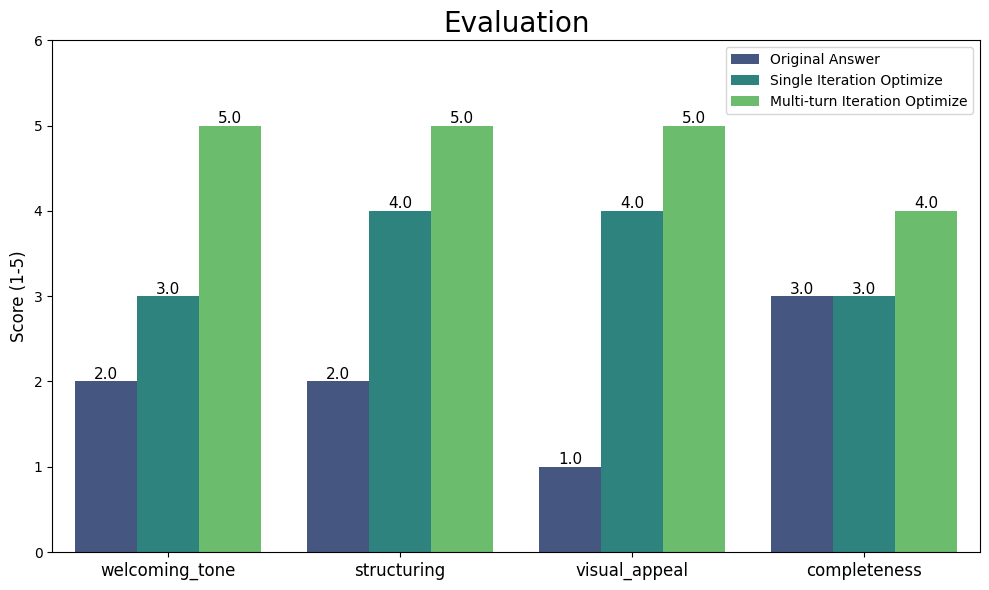

In [20]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 三个质量差异明显的典型回答样本
# 差：只是简单罗列信息，没有结构和感情
poor_response = "公司福利：健康保险，家属可用。15天年假，5天病假。交通补贴500，餐饮补贴300。培训基金8000。健身房有折扣。"

# 中：有基本结构和分类，但语气平淡
medium_response = """
公司福利：
1. 💦健康和假期：
   - 健康保险（含家属）
   - 年度体检
   - 15天年假和5天病假
2. 💰补贴和激励：
   - 每月500交通补贴和300餐饮补贴
   - 8000元/年的教育培训基金
   - 合作健身房折扣
"""

# 优：结构清晰、语气友好、视觉吸引力强（直接使用我们的参考答案）
good_response = reference_answer 

# 设计更细化的评估维度
def grade_response_detailed(response_to_grade):
    grader_prompt = f"""
    【角色】你是一位经验丰富的内部沟通和员工体验评测官。
    【任务】请根据以下四个维度，对提供的“公司福利介绍”文本进行1-5分的量化评分。
    
    【评分维度】
    1.  **欢迎语气 (welcoming_tone)**: 1分表示语气冰冷生硬，5分表示非常热情、有感染力。
    2.  **内容结构化 (structuring)**: 1分表示信息混乱无序，5分表示分类清晰、逻辑性强。
    3.  **视觉吸引力 (visual_appeal)**: 1分表示枯燥乏味，5分表示善用表情符号、粗体等元素，非常吸引眼球。
    4.  **信息完整性 (completeness)**: 1分表示信息缺失严重，5分表示关键福利信息完整无缺。

    【待评估文本】
    {response_to_grade}
    ---
    【输出要求】
    请严格以JSON格式返回你的评分，不要包含任何解释。例如：
    {{"welcoming_tone": 5, "structuring": 4, "visual_appeal": 5, "completeness": 5}}
    """
    try:
        raw_output = llm.invoke(grader_prompt)
        # 提取JSON部分
        json_str = raw_output[raw_output.find('{'):raw_output.rfind('}')+1]
        return json.loads(json_str)
    except (json.JSONDecodeError, IndexError):
        # 容错处理，在无法解析时返回一个默认的低分
        return {{"welcoming_tone": 1, "structuring": 1, "visual_appeal": 1, "completeness": 1}}

# 对三个典型样本进行评分
# 注意：这里的 key 将作为图表中的标签，我们使用新视觉方案中提供的名称
scores = {
    "Original Answer": grade_response_detailed(poor_response),
    "Single Iteration Optimize": grade_response_detailed(medium_response),
    "Multi-turn Iteration Optimize": grade_response_detailed(good_response)
}

# 将 scores 转换为 DataFrame
df = pd.DataFrame(scores)
df = df.reset_index().rename(columns={'index': 'Dim'})
df_long = df.melt(id_vars='Dim', var_name='Version', value_name='Score')


# --- 单幅分组柱状图 ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_long,
    x="Dim",        # 每个维度一组
    y="Score",
    hue="Version",  # 3 个版本并排
    palette="viridis"
)

# 为每根柱子添加数值标签
for p in ax.patches:
    height = p.get_height()
    if height == 0:          # 跳过高度为 0 的占位 patch
        continue
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='center',
        xytext=(0, 5),
        textcoords='offset points',
        fontsize=11
    )

# 轴和标题美化
ax.set_ylim(0, 6)
ax.set_ylabel('Score (1-5)', fontsize=12)
ax.set_xlabel('')                # 隐藏 X 轴标题
ax.set_title('Evaluation', fontsize=20)
ax.tick_params(axis='x', labelsize=12)

plt.legend()       # 显示图例
plt.tight_layout()
plt.show()


你可以看到，每次迭代的大模型的回复效果都有不同程度的提升。通过这种量化评估，你不仅能直观地看到每次优化带来的提升，还能将“好”或“不好”这种模糊的感觉，转化为清晰、可衡量的数据。这为你提供了一种科学的方法来验证和迭代你的提示词策略，确保每一步改进都有据可依，最终交付出真正高质量的用户体验。

### 4.7 让大模型帮你打造专属“AI 裁判”
上一节的自动化优化循环非常强大，但它引出了一个关键的工程问题：这个循环何时停止？
问题的关键在于，依赖“差距大不大”这种模糊的评价是不可靠的。你需要一个“**AI裁判**”，它能依据预设的量化标准，对每次优化结果给出明确的“**✅通过**”或“**❌不通过**”结论，从而为你的自动化流程提供一个清晰、可靠的停止条件。

<div align="center">
  <a href="https://img.alicdn.com/imgextra/i3/O1CN01pi2na21tDbDRT3Jna_!!6000000005868-2-tps-1115-614.png" target="_blank">
    <img src="https://img.alicdn.com/imgextra/i3/O1CN01pi2na21tDbDRT3Jna_!!6000000005868-2-tps-1115-614.png" width="600"/>
    </a>
  <p>图： 通过Meta-Prompting构造一个 “AI 裁判”，替代 analyze_gap() 方法，提升“判别”准确率。</p>
</div>


#### “AI 裁判” 的训练流程
打造“AI 裁判”的过程可以看作是在训练一个机器学习的分类器。你要打造的“AI裁判”提示词就是待训练的“模型”，而你准备的标准样本就是“数据集”。整个流程就是通过数据来“训练”你的“模型”。
1. **准备数据集**：首先创建一批高质量的标注样本（包含“好答案”与“坏答案”）。
2. **迭代“训练”**：
   - a. 将这批数据自动按比例（如 7:3）拆分为“训练集”和“评估集”。
   - b. 使用当前的“裁判提示词”，分别在**训练集**和**评估集**上进行“**预测**”，并记录下各自的准确率分数。
为什么要监控两个分数？
关注这两个分数的变化，能帮你判断“模型”是否出现了“过拟合”——即它只是“背会”了训练题，而对新题（评估集）的判断能力没有真正提升。
   - c. 找出在**训练集**上判断错误的“错题”。
   - d. 将这些“错题”连同你的分析，通过 Meta Prompting 的方式，让大模型帮你优化“裁判提示词”，生成一个新版本。
   - e. 重复 b-d 的步骤。你可以随时**停止“训练”**。

3. **停止“训练”**：
在每一轮迭代中，你需要介入分析：
   - 训练准确率和评估准确率是否都在稳步提升？
   - 评估准确率是否停滞或突然下降（可能过拟合）
   - 新产生的“错题”是否暴露了样本本身的模糊性或矛盾？（样本质量不好）

> 注意：如果样本质量不好，导致评价标准不一致或对同类问题给出模棱两可的判断，大模型可能永远也无法构造出一个性能优秀的“AI裁判”。这时，你可以停止迭代，先去优化你的样本数据。

最终，由你来决定何时停止“训练”，并采纳在评估集上表现最好的那个版本的提示词，作为你最终的“**AI 裁判**”。


<div align="center">
    <a href="https://img.alicdn.com/imgextra/i4/O1CN01udzBDT1JvGoUnS4sn_!!6000000001090-2-tps-2451-831.png" target="_blank">
    <img src="https://img.alicdn.com/imgextra/i4/O1CN01udzBDT1JvGoUnS4sn_!!6000000001090-2-tps-2451-831.png" width="800"/>
    </a>
  <p>图： 采用机器学习训练模型的思路来迭代 “AI 裁判”，并根据训练和评估阶段的准确率、召回率等指标的对比，决定是否结束训练。</p>
</div>



#### 4.7.1 准备与拆分数据集
   
首先，你需要一批由你或领域专家精心标注的样本。这是整个流程的基础，也是质量的基石。

In [22]:
# 准备一批高质量的标注样本
# 在实际应用中，这些样本可以上传到 AI 平台（如百炼）创建评估集
labeled_samples = [
    # --- 3个样本用于“训练” ---
    {
        "id": "train_01",
        "response": "公司福利：健康保险，家属可用。15天年假，5天病假。交通补贴500，餐饮补贴300。培训基金8000。健身房有折扣。", 
        "label": "不通过", 
    },
    {
        "id": "train_02",
        "response": """公司福利包括：\n1. 健康和假期：健康保险、年度体检、15天年假和5天病假。\n2. 补贴和激励：每月500交通补贴和300餐饮补贴，以及8000元的培训基金。""", 
        "label": "不通过", 
    },
    {
        "id": "train_03",
        "response": """👋 欢迎加入！我们为你准备了超棒的福利：\n- 🏥 全面健康保险和年度体检\n- 🌴 15天年假+5天病假\n- 💰 每月交通和餐饮补贴\n- 🎓 高达8000元的培训基金\n期待与你共事！🎉""", 
        "label": "通过", 
    },
    
    # --- 2个样本用于“评估” ---
    {
        "id": "eval_01",
        "response": "我们有健康保险、年假、病假、交通和餐饮补贴、培训基金和健身折扣。", 
        "label": "不通过", 
    },
    {
        "id": "eval_02",
        "response": """你好，新同事！公司福利很棒哦：\n- 健康方面有保险和体检。\n- 假期有年假和病假。\n- 钱的方面有补贴和教育基金。\n祝你工作愉快！""", 
        "label": "通过", 
    },
]

# 按比例拆分数据集（此处为手动模拟）
# 在实际项目中，可使用 scikit-learn 等库的 train_test_split 来随机拆分
train_set = labeled_samples[:3]
eval_set = labeled_samples[3:]

# 假设你已有一个 llm.invoke 函数
# from your_llm_library import llm 


#### 4.7.2 迭代“训练”

通过让模型不断学习“错题”，让“裁判提示词”变得越来越聪明。

In [23]:
# 定义一个辅助函数，用于在指定数据集上评估提示词的准确率
def evaluate_judge_prompt(judge_prompt, dataset):
    correct_predictions = 0

    misjudged_cases = [ ]

    
    for sample in dataset:
        prompt = judge_prompt.format(response_to_judge=sample["response"])
        
        # 模拟LLM调用，实际应为: predicted_label = llm.invoke(prompt)
        # 为了演示，这里手动模拟不同版本提示词的预测行为
        predicted_label = "通过" if "欢迎" in sample["response"] or "你好" in sample["response"] else "不通过" # 模拟v2版本的行为
        if "v1" in judge_prompt: # 模拟v1版本的宽松行为
             if "1." in sample["response"]: predicted_label = "通过"

        is_correct = (predicted_label == sample["label"])
        if is_correct:
            correct_predictions += 1
        else:
            misjudged_cases.append({
                "response": sample["response"],
                "current_judgment": predicted_label,
                "correct_judgment": sample["label"]
            })
            
    accuracy = correct_predictions / len(dataset)
    return accuracy, misjudged_cases

# ----------------- 迭代“训练”开始 -----------------

# a. 准备初始版的“裁判提示词” (v1.0)
judge_prompt_v1 = """
# v1
【角色】你是一位员工体验专家。
【任务】判断【待评估的回答】是否合格。
【评判标准】
1. 结构清晰: 信息分点或分类列出。
2. 信息完整: 提及核心福利。
【待评估的回答】
---
{response_to_judge}
---
【输出要求】请只回答“通过”或“不通过”。
"""

current_judge_prompt = judge_prompt_v1
max_iterations = 2 # 设置最大迭代次数，避免无限循环

for i in range(max_iterations):
    print(f"--- 第 {i+1} 轮迭代 ---")
    
    # b. 分别在训练集和评估集上“预测”并记录分数
    train_accuracy, misjudged_on_train = evaluate_judge_prompt(current_judge_prompt, train_set)
    eval_accuracy, _ = evaluate_judge_prompt(current_judge_prompt, eval_set)
    
    print(f"训练集准确率: {train_accuracy:.0%}")
    print(f"评估集准确率: {eval_accuracy:.0%}")

    # 如果训练集上已经没有错误，或者评估集准确率开始下降，你可以考虑停止
    if not misjudged_on_train:
        print("\n训练集上已无错误，训练完成。")
        break
        
    # c. 找出在训练集上判断错误的“错题”
    first_error = misjudged_on_train[0]
    print(f"\n发现错题: 模型将一个本应判为 '{first_error['correct_judgment']}' 的回答错判为 '{first_error['current_judgment']}'")

    # d. 将“错题”打包，让大模型帮你优化提示词
    judge_optimizer_prompt = f"""
    【角色】你是一位顶级的提示词工程师。
    【背景】我当前的裁判提示词在评估一个样本时犯了错误。
    
    【我当前的裁判提示词】
    ---
    {current_judge_prompt}
    ---
    
    【发生错误的案例】
    - 待评估的回答: "{first_error['response']}"
    - 我的工具的错误判断: "{first_error['current_judgment']}"
    - 我期望的正确判断: "{first_error['correct_judgment']}"
    - 我认为出错的原因是：当前标准太松，没有强调'热情友好'的语气。
    
    【任务】请重写我的裁判提示词，使其标准更严格，能修正上述错误。
    【要求】请只返回优化后的新提示词。
    """
    
    # 模拟调用优化器LLM，生成新版本的提示词
    # new_judge_prompt = llm.invoke(judge_optimizer_prompt)
    print("正在根据错题优化提示词...")
    new_judge_prompt = """
    # v2
    【角色】你是一位追求极致员工体验的内部沟通专家，眼光苛刻。
    【任务】严格判断【待评估的回答】是否合格。
    【评判标准】
    1.  **欢迎氛围 (必须满足)**: 必须有明确的、热情的欢迎语。
    2.  **结构化呈现 (必须满足)**: 必须使用列表或分段。
    【待评估的回答】
    ---
    {response_to_judge}
    ---
    【输出要求】请只回答“通过”或“不通过”。
    """
    
    # e. 更新为新版本的提示词，进入下一轮循环
    current_judge_prompt = new_judge_prompt
    print("-" * 20 + "\n")

print("\n--- 迭代结束 ---")
final_judge_prompt = current_judge_prompt


--- 第 1 轮迭代 ---
训练集准确率: 67%
评估集准确率: 100%

发现错题: 模型将一个本应判为 '不通过' 的回答错判为 '通过'
正在根据错题优化提示词...
--------------------

--- 第 2 轮迭代 ---
训练集准确率: 100%
评估集准确率: 100%

训练集上已无错误，训练完成。

--- 迭代结束 ---


#### 4.7.3 “足够优秀”，就可以“停止训练”
在上面的迭代循环中，你可以清楚地看到分数的变化：
- 第 1 轮迭代:

    - 训练集准确率: 67% (v1 提示词判错了 train_02)
    - 评估集准确率: 100% (v1 提示词恰好都判对了)
- 第 2 轮迭代:

    - 训练集准确率: 100% (v2 提示词修正了错误)
    - 评估集准确率: 100%

在这个简单的例子中，评估准确率始终很高。但在真实场景中，你可能会看到评估准确率停滞甚至下降。</br>
基于以上数据，你会发现 v2 版本的提示词在训练集和评估集上都达到了100%的准确率。因此，你可以采纳 `judge_prompt_v2` 作为你最终的、经过验证的“AI裁判”。如果评估结果不理想，你可能需要回到一开始，检查并优化你的 `labeled_samples`。

#### 4.7.4 用“AI裁判”指导自动化优化
现在你拥有了一个经过反复验证和测试的“AI裁判”（`final_judge_prompt`），可以投入使用了。</br>
你需要用它来替换 4.6 节中那个对比两个样本之间的差异来判断是否可用的评估环节，让整个流程变得更加严谨。

**新的工作流如下：**
1. **生成 (Generate)**：使用当前的“生成提示词”产出一个回答。
2. **判决 (Judge)**：调用你训练好的“AI裁判提示词”，对回答进行“通过/不通过”的判决。
3. **决策与优化 (Decide & Optimize)**：

    - 如果判决为“**通过**”，循环结束，优化成功。
    - 如果判决为“**不通过**”，则将“生成提示词”、“失败的回答”以及“**AI裁判的规则书**”（也就是它的提示词）一起交给“优化器”，让它根据明确的失败标准来生成新版提示词。

In [24]:
import os
from langchain_community.llms import Tongyi

# # --- 1. 定义“AI裁判”与“优化器” ---
# # 最终采纳的、经过验证的“AI裁判”提示词（可以采用下面这段提示词做模拟）
# final_judge_prompt = """
# # v2
# 【角色】你是一位追求极致员工体验的内部沟通专家，眼光苛刻。
# 【任务】严格判断【待评估的回答】是否合格。
# 【评判标准】
# 1.  **欢迎氛围 (必须满足)**: 必须有明确的、热情的欢迎语。
# 2.  **结构化呈现 (必须满足)**: 必须使用列表或分段。
# 【待评估的回答】
# ---
# {response_to_judge}
# ---
# 【输出要求】请只回答“通过”或“不通过”。
# """

# 定义一个更强大的优化函数，它直接参考“裁判”的规则
def optimize_with_judge_rules(current_prompt, failed_response, judge_prompt):
    """调用LLM来根据裁判的规则优化生成提示词"""
    optimizer_prompt = f"""
    【角色】你是一位顶级的提示词工程师。
    【背景】我有一个“生成提示词”，但它生成的回答未能通过“AI裁判”的审核。
    
    【生成提示词】
    ---
    {current_prompt}
    ---
    
    【它生成的失败回答】
    ---
    {failed_response}
    ---
    
    【AI裁判的规则书 (它失败的原因)】
    ---
    {judge_prompt}
    ---
    
    【任务】
    请仔细研究“AI裁判的规则书”，并重写“生成提示词”，确保新提示词能生成一个可以通过该规则审核的回答。
    
    【要求】
    请只返回优化后的新版“生成提示词”，不要包含任何其他说明或解释。
    """
    # 真实调用LLM进行优化
    new_prompt = llm.invoke(optimizer_prompt)
    return new_prompt

# --- 2. 运行由“AI裁判”驱动的自动化优化循环 ---
current_generating_prompt = initial_prompt
max_iterations = 5 # 可以增加最大迭代次数，尽管已经加入 AI 裁判，仍需防止意外的无限循环

print("\n" + "="*30)
print("开始最终的、由“AI裁判”驱动的自动化优化流程")
print("="*30 + "\n")

for i in range(max_iterations):
    print(f"--- 最终流程：第 {i+1} 轮迭代 ---")
    
    # 1. 生成回答 (真实调用)
    prompt_for_generator = current_generating_prompt.format(retrieved_text=retrieved_text)
    generated_response = llm.invoke(prompt_for_generator)
    
    print(f"生成的回答:\n---\n{generated_response}\n---")
    
    # 2. 调用“AI裁判”进行判决 (真实调用)
    judge_prompt_filled = final_judge_prompt.format(response_to_judge=generated_response)
    judgment = llm.invoke(judge_prompt_filled)
    
    # 清理judgment，只取核心词
    judgment_cleaned = judgment.strip().replace("。", "")
    print(f"“AI裁判”的判决: {judgment_cleaned}")

    # 3. 决策
    # 使用精确的“==”判断，避免“不通过”包含“通过”的逻辑错误
    if judgment_cleaned == "通过":
        print("\n✅ 优化成功！生成的回答已通过“AI裁判”的审核。")
        break
    else:
        print("❌ 未通过审核，正在根据“裁判”的规则进行优化...")
        current_generating_prompt = optimize_with_judge_rules(
            current_generating_prompt, 
            generated_response, 
            final_judge_prompt
        )
        print("-" * 20 + "\n")
else:
    print("\n达到最大迭代次数，停止优化。")

print("\n" + "="*30)
print("最终采纳的生成提示词：")
print("="*30)
print(current_generating_prompt)



开始最终的、由“AI裁判”驱动的自动化优化流程

--- 最终流程：第 1 轮迭代 ---
生成的回答:
---
您好！欢迎加入公司！以下是您关心的福利政策汇总，清晰明了，便于您快速了解：

✅ **健康保障**  
- 全面健康保险：覆盖员工本人及直系家属（配偶、子女、父母）；  
- 年度免费体检：每年一次，含基础项目与个性化可选项。

✅ **休假安排**  
- 带薪年假：15天/年（入职即享，随司龄增加可进一步提升）；  
- 带薪病假：5天/年（无需提供病假条，用于短期不适或就医）。

✅ **日常补贴**  
- 交通补贴：500元/月（随工资发放，无需报销）；  
- 餐饮补贴：300元/月（直接计入工资卡，灵活使用）。

✅ **学习与发展**  
- 教育培训基金：最高8000元/年，可用于：  
  • 线上/线下专业课程（如PMP、云计算、语言类等）；  
  • 考证报名费（如CFA、CPA、软考等）；  
  • 正版专业书籍、订阅行业数据库（如Coursera、O’Reilly）；  
  → 申请流程简单，HR将为您提供《基金使用指南》及季度申报通道。

✅ **健康生活支持**  
- 健身福利：与乐刻、超级猩猩、威尔士等多家连锁健身房合作，员工专享5–7折优惠，并可协助办理团体会员。

💡 小贴士：所有福利均自入职当月起生效（社保公积金按国家规定次月起缴）；详细细则、申请方式及合作机构清单，您可在入职后登录公司OA系统「员工福利平台」查看，或随时联系HRBP获取一对一指导。

祝您工作顺利、身心愉快！如有其他疑问，欢迎随时提出 😊
---
“AI裁判”的判决: 通过

✅ 优化成功！生成的回答已通过“AI裁判”的审核。

最终采纳的生成提示词：

根据以下信息，回答新员工关于公司福利的问题。

【参考信息】

关于公司的福利政策，我们提供全面的健康保险，覆盖员工及其直系家属。
年度体检是标配。此外，每年有15天的带薪年假，以及5天的带薪病假。
我们还提供每月500元的交通补贴和300元的餐饮补贴。
为了鼓励员工成长，公司设有每年高达8000元的教育培训基金，员工可以申请用于课程学习或购买专业书籍。
健身方面，公司与多家健身房有合作，员工可享受折扣价。




“**AI裁判**”可以让你的提示词优化流程变得更可控：
- 每当“生成提示词”产生一个新回答，就先让“AI裁判”来打分。</br>
- **通过了，代表优化成功；没通过，就将这个“坏答案”作为新材料，继续迭代优化你的生成提示词**。</br>

你可以始终采用这种思路，先打造“裁判”，再优化“选手”。构建一个可度量、可信赖、可自动化的“**提示词优化工程**”。

## 5. 推理大模型

前面所讲的提示词技巧和提示词框架可以广泛适用于通用大模型（如Qwen2.5-max、GPT-4、DeepSeek-V3），这类模型面向通用对话、知识问答、文本生成等广泛的场景。除了通用大模型，目前还有一类专门为“推理”设计的大模型——`推理大模型`。

### 5.1 什么是推理大模型?

你可能已经通过2.1节的扩展阅读了解了阿里云的推理大模型[Qwen3](https://help.aliyun.com/zh/model-studio/deep-thinking) 。为了方便本节后续调用，改写了2.1节中提供的代码，你可以尝试运行以下代码：

In [25]:
from openai import OpenAI
import os

def reasoning_model_response(user_prompt, system_prompt="你是一个编程助手。", model="qwen3-235b-a22b-thinking-2507"):
    """
    prompt: 用户输入的提示词
    model: 此处以 qwen3-235b-a22b-thinking-2507 为例，可按需更换推理模型名称，如：deepseek-r1
    """
    # 初始化客户端
    client = OpenAI(
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        base_url=os.getenv("BASE_URL")
    )

    # 初始化状态变量
    is_answering = False

    # 发起流式请求
    completion = client.chat.completions.create(
        model=model,
        # messages=[{"role": "user", "content": prompt}],
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        stream=True,
    )

    # 打印思考过程标题
    print("\n" + "=" * 20 + "思考过程" + "=" * 20 + "\n")

    # 处理流式响应
    for chunk in completion:
        if chunk.choices:
            delta = chunk.choices[0].delta
            if hasattr(delta, 'reasoning_content') and delta.reasoning_content is not None:
                # 处理思考过程内容
                print(delta.reasoning_content, end='', flush=True)
            else:
                # 切换到答案输出模式
                if delta.content != "" and not is_answering:
                    print("\n" + "=" * 20 + "完整回复" + "=" * 20 + "\n")
                    is_answering = True
                # 处理答案内容
                if delta.content:
                    print(delta.content, end='', flush=True)

In [26]:
reasoning_model_response(user_prompt="你是谁？")


====================思考过程====================

好的，用户问“你是谁？”，我需要先确认他的意图。可能他想了解我的身份，或者测试我的反应。作为编程助手，我应该明确说明自己的角色，同时保持友好。

首先，要回答我是通义千问，由通义实验室研发的AI助手，专注于编程相关的问题。然后，可能需要提供一些具体的例子，比如帮助解决代码问题、解释编程概念等，这样用户更清楚我的功能。

还要考虑用户可能的深层需求。他可能刚接触编程，遇到问题需要帮助，或者想确认我是否能提供有效的支持。所以，回答里应该鼓励他提出具体问题，这样能更好地帮助他。

另外，保持语言简洁，避免技术术语太多，让回答更易懂。需要检查有没有遗漏的关键点，比如是否提到支持多种编程语言，或者是否有其他功能需要说明。

最后，确保语气友好，用表情符号或者亲切的措辞，让用户感觉亲切，愿意继续互动。比如用“😊”或者“随时为你效劳！”这样的结尾。
====================完整回复====================

你好！我是 **Qwen**，由通义实验室研发的AI助手，专注于编程和代码相关的问题。你可以叫我通义千问，但我的“特长”是帮你：

- 解决代码问题（比如调试、优化、报错分析）
- 解释编程概念（比如递归、闭包、多线程）
- 提供代码示例（Python、JavaScript、Java、C++等）
- 推荐学习资源或工具

如果你有具体的编程问题，直接告诉我，我会尽力帮你搞定！ 😊  
（比如：“为什么这段Python代码报错？” 或 “如何用JavaScript实现一个计时器？”）


通过例子可以看到，推理模型相较于通用大模型多出了“`思考过程`”，就像解数学题时有人会先在草稿纸上一步步推导，而不是直接报答案，减少模型出现“拍脑袋”的错误，同时在分步思考过程中，如果某一步骤发现矛盾，还可以回头检查并重新调整思路，展示推理步骤还可以方便人们理解，顺着模型的思考路线验证逻辑。<br>
相较于通用大模型，推理大模型通常在解决复杂问题时更可靠，比如在数学解题、代码编写、法律案件分析等需要严谨推理的场景。并不是说推理模型一定更好，两种模型都有各自的应用场景，下表从一些典型维度对这两类模型进行了对比：<br>

| 维度            | 推理模型  | 通用模型  |
|-------------------|------------------|------------|
| 设计目标     | 专注于**逻辑推理、多步问题求解、数学计算**等需要深度分析的任务 | 面向**通用对话、知识问答、文本生成**等广泛场景 |
| 训练数据侧重  | 大量**数学题解、代码逻辑、科学推理**数据集增强推理能力 | 覆盖**百科、文学、对话**等多领域海量数据 |
| 典型输出特征 | 输出包含**完整推导**步骤，注重逻辑链条的完整性 | 输出**简洁直接**，侧重结果的自然语言表达 |
| 响应速度 | 复杂推理任务**响应较慢**（需多步计算） | 常规任务**响应更快**（单步生成为主） |

推理模型还是通用模型？如何选择？以下是一些推荐：
- **明确的通用任务**：对于明确定义的问题，**通用模型**一般能够很好地处理。
- **复杂任务**：对于非常复杂的任务，且需要给出相对**更精确和可靠**的答案，推荐使用**推理模型**。这些任务可能有：
    - 模糊的任务：任务相关信息很少，你无法提供模型相对明确的指引。
    - 大海捞针：传递大量非结构化数据，提取最相关的信息或寻找关联/差别。
    - 调试和改进代码：需要审查并进一步调试、改进大量代码。
- **速度和成本**：一般来说推理模型的推理时间较长，如果你对于时间和成本敏感，且任务复杂度不高，**通用模型**可能是更好的选择。<br>

当然你还可以在你的应用中结合使用两种模型：使用推理模型完成Agent的规划和决策，使用通用模型完成任务执行。

### 5.2 适用于推理大模型的提示词技巧

推理模型在面对相对模糊的任务也能给出详尽且格式良好的响应。你依然可以通过**提示词技巧**保证推理大模型的推理质量的下限：<br>
#### 技巧一：保持任务提示简洁清晰，提供足够的背景信息<br>
本节4.1中介绍的**清晰表达需求**同样适用于推理模型，虽然推理模型能力很强，但却不能“看穿人的想法”，你需要保持提示**简洁、清晰**，从而让推理大模型专注于核心任务。<br>

In [ ]:
bad_prompt="""
def example(a):
  b = []
  for i in range(len(a)):
    b.append(a[i]*2)
  return sum(b)
"""

reasoning_model_response(user_prompt=bad_prompt)

通过如上示例，可以看到就算你只给推理大模型一段代码，它还是能够通过一系列的推理给出很丰富的答案，但返回的推理中可能包含了很多你不关注的信息，你可以尝试明确**任务目标**，从而获得更有针对性的建议：

In [ ]:
prompt_A="""
如下 python 代码有什么问题？怎么优化？
def example(a):
  b = []
  for i in range(len(a)):
    b.append(a[i]*2)
  return sum(b)
"""

reasoning_model_response(user_prompt=prompt_A)

同样地，你还可以在结合本节**4.2 限定角色和受众**、**4.3规定输出格式**等技巧进一步限定范围，确保结果符合你的预期。<br>
同时，如果提示词比较复杂，你可以通过**分隔符**帮助模型理解你的意图。<br>

In [27]:
prompt_B="""
<audience>初级Python开发者</audience>

<task>函数性能优化，优化code中的代码。</task>

<format>
如有多种优化方案请按照如下格式进行输出：
【优化方案X】
问题描述：[描述]
优化方案：[描述]
示例代码：[代码块]
</format>

<code>
def example(a):
  b = []
  for i in range(len(a)):
    b.append(a[i]*2)
  return sum(b)
</code>
"""

reasoning_model_response(user_prompt=prompt_B)


====================思考过程====================

首先，我需要分析给定的代码，找出可以优化的地方。这是一个针对初级Python开发者的任务，所以我应该提供清晰、易懂的优化方案。

给定的代码是：
```python
def example(a):
  b = []
  for i in range(len(a)):
    b.append(a[i]*2)
  return sum(b)
```

这个函数的功能是：
1. 创建一个空列表b
2. 遍历输入列表a的每个元素
3. 将每个元素乘以2后添加到列表b中
4. 返回列表b中所有元素的和

现在，我来分析可能的优化点：

1. **避免显式循环**：Python中列表推导式通常比显式for循环更快，因为它们在C级别实现。
2. **避免创建中间列表**：当前代码先创建了一个新列表b，然后再求和。我们可以直接计算总和，而不必存储中间结果。
3. **使用内置函数**：Python的内置函数通常经过优化，比手动实现的循环更快。

让我详细分析每个优化点：

### 优化点1：使用列表推导式代替显式循环
当前代码使用了显式for循环来构建列表b。我们可以用列表推导式来简化这个过程。

原代码：
```python
b = []
for i in range(len(a)):
  b.append(a[i]*2)
```

优化后：
```python
b = [a[i]*2 for i in range(len(a))]
```

但这仍然创建了中间列表b。

### 优化点2：避免创建中间列表
当前代码先创建了列表b，然后计算sum(b)。实际上，我们不需要存储所有乘以2的值，只需要它们的总和。

我们可以直接计算总和：
```python
total = 0
for i in range(len(a)):
  total += a[i]*2
return total
```

或者更简洁地：
```python
return sum(a[i]*2 for i in range(len(a)))
```

这里我们使用了生成器表达式，它不会创建中间列表，而是逐个生成值并求和。

### 优化点3：直接迭代列表元素
当前代码使用了`range(len(a))`来获取索引，然

#### 技巧二：避免思维链提示
本节 4.5 中你了解到通过思维链（COT）技术让大模型深入思考提升回复效果。
一般来说，你无需提示推理模型“逐步思考”或“解释你的推理”，因为它们本身会进行深入的思考，你的提示可能反而限制推理模型的发挥。除非你需要大模型严格按照固定的思路去推理，这种情况很少发生。

#### 技巧三：根据模型响应调整提示词
推理模型因其回复形式(包含**思考过程**)，天然适合你分析它的思考推理结论的过程，便于你调整提示词。
因此，你不需要纠结提示词是否足够完善，只需要不断与推理模型对话，过程中补充信息，完善提示词即可。
比如当你的描述**太抽象**或**无法准确描述**时，你可以用本节4.4讲到的**增加示例**的技巧来明确这些信息，这些示例有时可以从与模型的对话历史中挑选出来。
这个过程可以是重复多次的，不断尝试调整提示，让模型不断推理迭代，直到符合你的要求。

#### 技巧四：让推理模型成为你的“提示词教练”

在 4.6 节中，你学习了 **Meta Prompting**，即让大模型帮助你优化提示词。那么，哪种模型最适合扮演这位“教练”的角色呢？

答案是**推理模型**。

由于推理模型擅长分步思考和逻辑推导，它们在分析一个提示词的优缺点、并系统性地提出改进建议方面表现得尤为出色。它们不仅能给你一个更好的提示词，还能清晰地展示出“为什么”这样改会更好，让你在优化过程中也能学到提示词工程的精髓。

让我们重新审视 4.6 节中的例子，但这次，我们使用在 6.1 节中定义的 `reasoning_model_response` 函数来充当我们的提示词教练。

In [28]:
# 我们将复用 4.6 节中的公司福利场景
retrieved_text = """
关于公司的福利政策，我们提供全面的健康保险，覆盖员工及其直系家属。
年度体检是标配。此外，每年有15天的带薪年假，以及5天的带薪病假。
我们还提供每月500元的交通补贴和300元的餐饮补贴。
为了鼓励员工成长，公司设有每年高达8000元的教育培训基金，员工可以申请用于课程学习或购买专业书籍。
健身方面，公司与多家健身房有合作，员工可享受折扣价。
"""

# 初始的、比较简单的提示词
initial_prompt = f"""
根据以下信息，回答新员工关于公司福利的问题。

【参考信息】
{retrieved_text}
"""

# 假设这是通用模型的、不甚理想的输出
initial_response = """
我们公司提供全面的健康保险，覆盖员工及其家属。每年有15天带薪年假和5天病假。还有每月500元交通补贴和300元餐饮补贴。公司提供8000元的年度教育基金，并与健身房有合作折扣。
"""

# 构建我们的 Meta Prompt，请求推理模型帮助优化
meta_prompt_for_reasoning = f"""
我正在为公司的新员工答疑机器人优化一个提示词，目标是回答关于“公司福利”的问题。

这是我的第一个尝试：
---\n{initial_prompt}\n---

这是它生成的输出：
---\n{initial_response}\n---

这个输出不够好。我希望机器人的回答更具吸引力，并且结构清晰，能让新员工快速抓住重点。具体要求如下：
1.  **语气**：友好、热情，有欢迎新同事的感觉。
2.  **结构**：使用清晰的要点（比如用表情符号开头的列表）来组织内容。
3.  **内容**：将福利分为几个类别，如“健康与假期”、“补贴与激励”等。

请你扮演一位提示词工程专家，帮我重写这个提示词，以实现上述目标。
请在最终答案中，只给出优化后的提示词本身，不要包含其他解释性文字。
"""

# 使用推理模型来获取优化建议
reasoning_model_response(user_prompt=meta_prompt_for_reasoning, system_prompt="你是一位顶级的提示词工程专家。")


====================思考过程====================

首先，用户要求我扮演顶级提示词工程专家，帮助优化一个提示词。目标是让新员工答疑机器人回答关于“公司福利”的问题。

用户提供了第一个尝试的提示词和生成的输出。输出不够好，因为它缺乏吸引力、结构不清晰。用户指定了具体要求：

1. **语气**：友好、热情，有欢迎新同事的感觉。

2. **结构**：使用清晰的要点（比如用表情符号开头的列表）来组织内容。

3. **内容**：将福利分为几个类别，如“健康与假期”、“补贴与激励”等。

用户说：在最终答案中，只给出优化后的提示词本身，不要包含其他解释性文字。所以，我的响应应该只包含优化后的提示词。

现在，回顾原提示词：

---

根据以下信息，回答新员工关于公司福利的问题。

【参考信息】

关于公司的福利政策，我们提供全面的健康保险，覆盖员工及其直系家属。

年度体检是标配。此外，每年有15天的带薪年假，以及5天的带薪病假。

我们还提供每月500元的交通补贴和300元的餐饮补贴。

为了鼓励员工成长，公司设有每年高达8000元的教育培训基金，员工可以申请用于课程学习或购买专业书籍。

健身方面，公司与多家健身房有合作，员工可享受折扣价。

---

生成的输出是：

---

我们公司提供全面的健康保险，覆盖员工及其家属。每年有15天带薪年假和5天病假。还有每月500元交通补贴和300元餐饮补贴。公司提供8000元的年度教育基金，并与健身房有合作折扣。

---

用户说这个输出不够好，因为它没有结构、不吸引人。

我需要重写提示词，以确保输出满足要求：

- 友好、热情的语气：提示词中应该指定语气，比如“用友好的、热情的语气回答，像在欢迎新同事”。

- 结构：使用表情符号开头的列表。提示词中应指示“使用要点列表，每个要点以表情符号开头”。

- 内容：将福利分为类别。用户建议“健康与假期”、“补贴与激励”等。所以，在提示词中，我应该定义这些类别。

参考信息中福利包括：

- 健康保险

- 年度体检

- 带薪年假和病假

- 交通补贴

- 餐饮补贴

- 教育培训基金

- 健身房折扣

我可以将它们分为：

- 健康与假期：健康保险、年度体检、带薪年假、带薪病假

- 补贴与激励：交通补贴、餐饮补贴、教育培

通过上面的示例，你可以清晰地看到推理模型是如何一步步分析原始提示词的不足，并结合我们提出的要求（友好的语气、清晰的结构、生动的内容等），最终构建出一个结构更加严谨、意图更加明确的优化版提示词。

这充分展示了将合适的工具用在合适的任务上的重要性，这背后是 **任务复杂性** 与 **执行成本（时间与费用）** 之间的权衡：

- **通用模型（非推理模型）**：
    - **优势**：执行速度快，成本较低。
    - **适用场景**：适合执行相对直接、明确的任务，例如根据一个已经优化好的提示词进行信息提取、格式转换或简单问答。

- **推理模型**：
    - **优势**：擅长处理复杂、模糊或需要深度逻辑推导的任务。
    - **适用场景**：更适合执行“元任务”（meta-task），例如分析和优化另一个任务（即提示词本身）的定义、进行复杂的规划或调试代码。
    - **成本**：由于需要进行多步思考，其响应时间通常更长，成本也相对更高。

在你构建自己的大模型应用时，**混合使用这两种模型**往往是实现最佳性价比的策略。你可以借鉴这种思路，构建一个“分工明确”的智能系统：
当任务需要深度思考或规划时，引入推理模型来充当“**规划师**”或“**分析师**”的角色，让它来分解复杂任务或优化流程；然后，将拆解后的、更简单的子任务交由**通用模型**或其他工具来高效、低成本地执行。这种协作模式，能让你在保证高质量输出的同时，有效控制应用的响应时间和运行成本。

## ✅ 本节小结

通过学习本节课程，你掌握了更多**上下文工程（Context Engineering）** 的高级技巧，从设计精细的提示词到实现智能的意图路由。回顾过去两节课，我们已经为答疑机器人装备了两大核心能力：<br>
1. **知识填充 (通过 RAG)**：解决了模型“不知道”私有信息的问题。
2. **行为引导 (通过提示词与控制流)**：解决了模型“如何做”、“做什么”的问题。
这些技巧的共同核心，正是上下文工程的精髓：<br>
通过精心设计和填充模型的上下文窗口，来引导和控制其生成期望的输出——这对于你用好大模型至关重要。

实际落地大模型应用的过程中，提示词部分经常让领域专家来共同设计。因此，在你的工程代码中硬编码提示词，应该考虑调整成可配置的，甚至应用流程也可配置，这样能更方便领域专家参与提示词和整个流程的设计。阿里云百炼提供了可视化的大模型[应用构建](https://help.aliyun.com/zh/model-studio/user-guide/application-introduction#7c79befb2djg9)能力，可以在页面上完成提示词编写、整个复杂应用的流程可视化搭建，非常适合在需要非技术背景的领域专家参与的大模型应用开发项目中。

在下一节中，你将学习自动化评测方法测试答疑机器人的表现，你可以使用量化的指标来评测你通过上下文工程所做的优化效果。



## 🔥 课后小测验

### 🔍 单选题
<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>以下哪个提示词要素用于明确要求大模型完成的任务❓</b>

- A. 角色 (Role)     
- B. 受众 (Audience)   
- C. 任务目标 (Object)  
- D. 上下文 (Context)  

**【点击查看答案】**
</summary>

<div style="margin-top: 10px; padding: 15px;  border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **参考答案：C**  
📝 **解析**：
- 任务目标 (Object) 明确规定了大模型需要执行的操作或达成的结果。其他选项并非直接定义任务本身。
- 角色 (Role) 定义大模型扮演的身份，受众 (Audience) 定义目标群体，上下文 (Context) 提供背景信息。


</div>
</details>

---


### 🔍 多选题
<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>你接手了一个复杂的、用于生成代码的提示词，但缺乏相关文档。在直接修改这个“黑盒”提示词之前，你会执行哪些准备工作来确保后续优化的有效性？</b>

- A. 收集模型输出不佳的具体案例（Bad Cases）。
- B. 立即开始草拟一个全新的、更简单的替代版本。
- C. 清晰地用文字描述出期望的输出标准和格式。
- D. 通读整个提示词，尝试凭直觉找出逻辑漏洞。

**【点击查看答案】**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **参考答案：A,C**  
📝 **解析**：
本题考查在启动一个结构化优化流程前，必须具备哪些核心输入。正确的优化（如Meta Prompting）需要明确的“问题”和“目标”。
- 选项A（坏样本）和选项C（期望输出）是定义“问题”和“目标”的关键步骤，是Meta Prompting方法的两个核心输入。
- 选项B（推倒重来）和选项D（凭直觉修改）都是高风险低效率的方法，它们没有考虑系统的结构，也没有考虑系统的效果。"

</div>
</details>


---


### 🔍 多选题
<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>在使用推理型大模型（如qwen3-235b-a22b-thinking-2507）执行深度思考任务时。以下哪些提示词技巧是推荐的❓</b>

- A. 给出简单、明确的任务指示    
- B. 补充足够的背景信息     
- C. 如有特定用户群体或特定任务要求，设定角色或受众     
- D. 必须在提示词里写“一步一步推理”或者“给出解释”，模型才会使用深度思考模式
- E. 当描述太抽象或无法准确描述时，可以通过增加示例来明确这些信息 

**【点击查看答案】**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **参考答案：ABCE**  
📝 **解析**：
- 通常情况下，推理型大模型（如qwen3-235b-a22b-thinking-2507）无需显式要求即可通过类似“思维链”（chain of thought）的模式做深度思考。

</div>
</details>

## ✉️ 评价反馈

感谢你学习阿里云大模型ACP认证课程，如果你觉得课程有哪里写得好、哪里写得不好，期待你[通过问卷提交评价和反馈](https://survey.aliyun.com/apps/zhiliao/Mo5O9vuie)。

你的批评和鼓励都是我们前进的动力。